# influence

In [281]:
def grad(x,y,w,lam):
    ## gradient of logistic loss dl/dw
    # y is n*1
    # x is n*p data
    # w is p*1 column vector
    # g is n*p gradient matrix
    if len(y.shape)==1:
        y = np.reshape(y,(y.shape[0],1))
    if w.shape[0]==1:
        w = np.reshape(w, (w.shape[1],1))
    n = y.shape[0]
    a = np.multiply(y,x)
    b = (1+np.exp(np.multiply(y,np.dot(x,w))))
    c = lam*np.transpose(w)
    g = -np.divide(a,b) + c
    
    return g

In [282]:
def hessian(x,y,w,lam):
    ## Hessian of logistic loss d^2l/dw^2
    # y is n*1
    # x is n*p data
    # w is p*1 column vector
    # h size p*p matrix
    if len(x.shape)==1:
        x = np.reshape(x,(1,x.shape[0]))
        y = np.array([y])
    
    if len(y.shape)==1:
        y = np.reshape(y,(y.shape[0],1))
    if w.shape[0]==1:
        w = np.reshape(w, (w.shape[1],1))
    D = np.zeros((x.shape[0],x.shape[0]))
    
    for i in range(x.shape[0]):
        sig = 1/(1+np.exp(-y[i]*np.dot(x[i],w)))
        D[i,i] = sig*(1-sig)
    
    h = (np.dot(np.dot(np.transpose(x), D), x) + lam)*(1/y.shape[0])
    return h

In [283]:
def log_d(x,y,beta):
    # gradient of logistic loss dl/dbeta
    # y in n*1 response vector
    # x in n*p data matrix
    # beta in p*1 column vector
    # g in n*p gradient matrix
    if len(y.shape)==1:
        y = np.reshape(y,(y.shape[0],1))
    a = np.dot(x,np.transpose(beta))
    b = -np.transpose(np.multiply(np.transpose(y),np.transpose(x)))
#     print(x.shape,y.shape,beta.shape,a.shape,b.shape)
    g = np.divide(b,(1+np.exp(y*(a))))
    return g


In [333]:
def log_dd(x,y,beta):
    # Hessian of logistic loss d^2l/dbeta^2
    # y in R
    # x in R^p row vector
    # beta in R^p column vector
    # h size p*p matrix
#     print(x.shape,y.shape,beta.shape)
    h = np.divide(np.dot(np.transpose(x),x),(2+np.exp(-np.dot(beta,x))+np.exp(np.dot(beta,x))))
    return h

In [338]:
m = LogisticRegression(C=lam)
m.fit(X_train,y_train)
w = m.coef_
lam = 0.001
lam = 1/lam
dd = hessian(X_train,y_train,w,lam)
dd

array([[10.0866692 , 10.06631215],
       [10.06631215, 10.08710078]])

In [339]:
def inf_debug(X_train, y_train, X_trust, y_trust, gamma, lam):
    ## Influence function for binary classification

    n = y_train.shape[0]
    m = X_trust.shape[0]
    
    # prepare the RBF kernel matrix 
    K_train = np.hstack((rbf_kernel(X_train,X_train,gamma=gamma),np.ones((n,1))))
    K_trust = np.hstack((rbf_kernel(X_trust,X_train,gamma=gamma),np.ones((m,1))))
#     print(K_train.shape,y_train.shape)

    lr = LogisticRegression(C=lam)
    lr.fit(K_train,y_train)
    w = lr.coef_ 
    
    f1 = grad(K_trust,y_trust,w,lam)
    f2 = np.linalg.pinv(hessian(K_train,y_train,w,lam))
    f3 = grad(K_train,y_train,w,lam)
#     print(f1.shape, f2.shape, f3.shape,w.shape)
    
    inf = -np.dot(f1,np.dot(f2,np.transpose(f3)))
    
    # Xuezhou method
    
    alpha = w
    # Compute (d alpha/d w)
#     print(K_train.shape, y_train.shape)
    dhdw = (1/n)*np.transpose(y_train)*np.transpose(K_train)
    dhdalpha = np.zeros((n+1,n+1))
    
    dhdalpha[:n,:n] = lam*K_train[:,:n]
    
    for i in range(n):
        dhdalpha = dhdalpha + (1/n)*log_dd(K_train[i,:],y_train[i],alpha);

    dalphadw = -np.dot(np.linalg.pinv(dhdalpha),dhdw)

    a = log_d(K_trust,y_trust,alpha)
#     print(a.shape)
    I_inf = np.dot(np.sum(a,0),dalphadw)
        
#     inf = [(i,inf[i]) for i in range(inf.shape[0])]
#     I_inf = [(i,I_inf[i]) for i in range(I_inf.shape[0])]
    
    return inf, I_inf


# experiments: influence

In [352]:
inf, I_inf = inf_debug(X_train, y_train, X_trust, y_trust, gamma, lam)
print(inf.shape,I_inf.shape)
I_inf = [(i,I_inf[i]) for i in range(I_inf.shape[0])]

(2, 100) (100,)


In [353]:
def get_relevant_influences(X_train, y_train, X_trust, y_trust, clf, gamma, inf):
    
    influences = [] 
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    K_trust = rbf_kernel(X_trust, X_train, gamma=gamma)
    clf.fit(K, y_train)
    y_trust_pred = clf.predict(K_trust)
    
    l = []
    for i in range(len(y_trust)):
        if y_trust_pred[i] != y_trust[i]:
            pass
            l.append(i)
        
    for i in range(X_train.shape[0]):
        influences.append((i, np.sum(inf[l,i])))
                
    return influences

In [354]:
I_inf.sort(key = lambda x: x[1], reverse=True)
I_inf[:10]

[(99, 0.0017930493740838471),
 (89, 0.0017774741180054136),
 (79, 0.0017709490901152741),
 (69, 0.00176399432294512),
 (59, 0.0017594346097007795),
 (98, 0.0017593036421447183),
 (88, 0.0017475986128576964),
 (78, 0.0017461325856289232),
 (58, 0.0017416927129316857),
 (68, 0.0017411801174258897)]

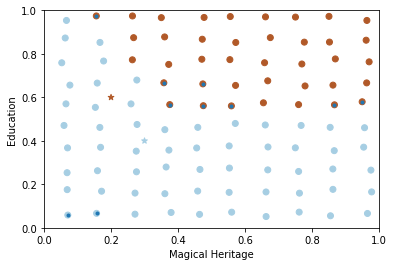

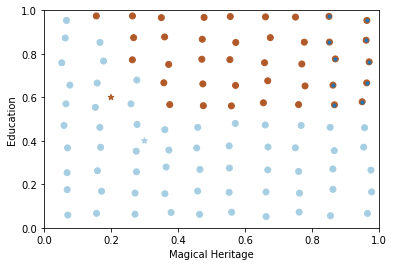

In [355]:
n = 10
top_n = True
# top_n = False

influences_1 = get_relevant_influences(X_train, y_train, X_trust, y_trust, clf, gamma, inf)
influences_2 = I_inf[:]

visualize_top_influential_points(X_train, y_train, influences_1, n, top_n, X_trust, y_trust)
visualize_top_influential_points(X_train, y_train, influences_2, n, top_n, X_trust, y_trust)

# experiments

In [356]:
from sklearn.metrics import log_loss

In [357]:
def calculate_influences_self(X_train, y_train, clf, gamma):
    influences = []
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    clf.fit(K, y_train)
    probas = clf.predict_proba(K)[:,1]
    print(K.shape)
    
    for i in range(X_train.shape[0]):        
        K_point = K[i,:].reshape((1,X_train.shape[0]))
        
        orig_loss = custom_log_loss(y_train[i], probas[i])
        
        
        X_train_mod = np.delete(X_train, i, 0)
        y_train_mod = np.delete(y_train, i, 0)
        
        K_mod = rbf_kernel(X_train_mod, X_train_mod, gamma=gamma)
        
        clf.fit(K_mod, y_train_mod)
        
        K_mod_point = rbf_kernel(X_train[i].reshape((1,X_train.shape[1])),X_train_mod,gamma=gamma)
        point_proba = clf.predict_proba(K_mod_point)[:,1]
        mod_loss = custom_log_loss(y_train[i], point_proba)
        
#         print(y_train[i],probas[i],orig_loss)
#         print(y_train[i],point_proba,mod_loss)

        
        influences.append((i, mod_loss - orig_loss))
        
    return influences

In [358]:
influences_self = calculate_influences_self(X_train, y_train, clf, gamma)

(100, 100)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


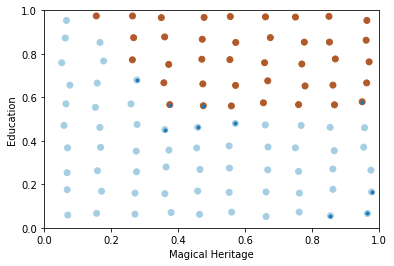

In [359]:
n = 10
top_n = True
# top_n = False
visualize_top_influential_points(X_train, y_train, influences_self, n, top_n)

Flip a single point, influence = change in training error

In [360]:
def calculate_influences_flip(X_train, y_train, clf, gamma):
    influences = []
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    clf.fit(K, y_train)
    orig_loss = log_loss(y_train, clf.predict_proba(K))
#     print(log_loss(y_train, clf.predict_proba(K)), custom_log_loss(y_train, clf.predict_proba(K)[:,1]))
    
    for i in range(X_train.shape[0]):
        y_train_mod = np.copy(y_train)
        y_train_mod[i] = 0 if (y_train_mod[i]==1) else 1 # flip single label
        
        clf.fit(K, y_train_mod)
        mod_loss = log_loss(y_train_mod, clf.predict_proba(K))
        
        influences.append((i, mod_loss - orig_loss))
                
    return influences

In [361]:
influences_flip = calculate_influences_flip(X_train, y_train, clf, gamma)

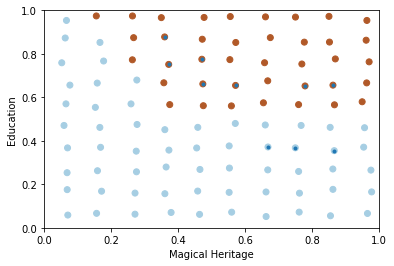

In [364]:
n = 10
top_n = True
# top_n = False
visualize_top_influential_points(X_train, y_train, influences_flip, n, top_n)

Delete a single point, influence = change in training error

In [365]:
def calculate_influences_delete(X_train, y_train, clf, gamma):
    influences = []
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    clf.fit(K, y_train)
    orig_loss = log_loss(y_train, clf.predict_proba(K))
    
    for i in range(X_train.shape[0]):
        X_train_mod = np.delete(X_train, i, 0)
        y_train_mod = np.delete(y_train, i, 0)
        
        K_mod = rbf_kernel(X_train_mod, X_train_mod, gamma=gamma)
        clf.fit(K_mod, y_train_mod)
        mod_loss = log_loss(y_train_mod, clf.predict_proba(K_mod))
        
        influences.append((i, mod_loss - orig_loss))
        
        
    return influences

In [366]:
influences_delete = calculate_influences_delete(X_train, y_train, clf, gamma)

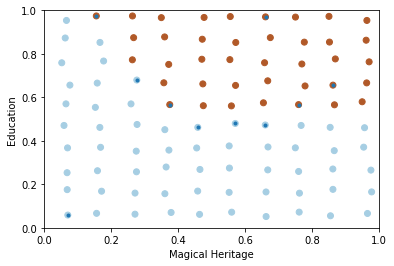

In [368]:
n = 10
top_n = True
top_n = False
visualize_top_influential_points(X_train, y_train, influences_delete, n, top_n)

Flip one label at a time, influence = change in loss of misclassified trusted items

In [386]:
def custom_log_loss(y_true, y_proba):
    return -np.mean(np.multiply(y_true, np.log(y_proba))+np.multiply(1-y_true, np.log(1-y_proba)))

In [387]:
def calculate_influences_on_trust_flip(X_train, y_train, X_trust, y_trust, clf, gamma):
    influences = []
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    K_trust = rbf_kernel(X_trust, X_train, gamma=gamma)
    clf.fit(K, y_train)
    y_trust_pred = clf.predict(K_trust)
    
    l = []
    for i in range(len(y_trust)):
        if y_trust_pred[i] != y_trust[i]:
            pass
            l.append(i)
    X_trust_misclassified = X_trust[l]
    y_trust_misclassified = y_trust[l]
    
    K_trust_misclassified = K_trust[l]
    trust_misclassified_proba = clf.predict_proba(K_trust_misclassified)[:,1]
    orig_loss = custom_log_loss(y_trust[l], trust_misclassified_proba)
#     print(y_trust[l],trust_misclassified_proba,orig_loss)
    
    for i in range(X_train.shape[0]):
        y_train_mod = np.copy(y_train)
        y_train_mod[i] = 0 if (y_train_mod[i]==1) else 1 # flip single label
        
        clf.fit(K, y_train_mod)
        
#         y_trust_pred = clf.predict(K_trust)
#         l = []
#         for j in range(len(y_trust)):
#             if y_trust_pred[j] != y_trust[j]:
#                 pass
#             l.append(j)

#         X_trust_misclassified = X_trust[l]
#         y_trust_misclassified = y_trust[l]

#         K_trust_misclassified = rbf_kernel(X_trust_misclassified, X_train, gamma=gamma)
        
        trust_misclassified_proba = clf.predict_proba(K_trust_misclassified)[:,1]
        mod_loss = custom_log_loss(y_trust[l], trust_misclassified_proba)
        
#         print(y_trust[l],y_trust_misclassified,trust_misclassified_proba)
        
        influences.append((i, -(mod_loss - orig_loss)))
                
    return influences

In [388]:
influences_flip_trust = calculate_influences_on_trust_flip(X_train, y_train, X_trust, y_trust,clf, gamma)

In [389]:
c = [(influences_flip_trust[i],X_train[i]) for i in range(len(influences_flip_trust))]
c.sort(key=lambda x:x[0][1], reverse=True)

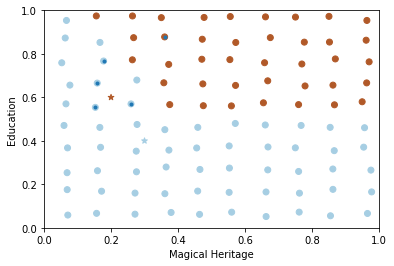

In [390]:
n = 5
top_n = True
# top_n = False
visualize_top_influential_points(X_train, y_train, influences_flip_trust, n, top_n, X_trust, y_trust)

In [378]:
def calculate_influences_on_trust_delete(X_train, y_train, X_trust, y_trust, clf, gamma):
    influences = []
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    K_trust = rbf_kernel(X_trust, X_train, gamma=gamma)
    clf.fit(K, y_train)
    
    y_trust_pred = clf.predict(K_trust)
    l = []
    for i in range(len(y_trust)):
        if y_trust_pred[i] != y_trust[i]:
            l.append(i)
    X_trust_misclassified = X_trust[l]
    y_trust_misclassified = y_trust[l]
    
    K_trust_misclassified = rbf_kernel(X_trust_misclassified, X_train, gamma=gamma)
    orig_loss = -custom_log_loss(y_trust_pred[l], clf.predict_proba(K_trust_misclassified)[:,1])
    
    for i in range(X_train.shape[0]):
        X_train_mod = np.delete(X_train, i, 0)
        y_train_mod = np.delete(y_train, i, 0)
        
        K_mod = rbf_kernel(X_train_mod, X_train_mod, gamma=gamma)
        K_trust = rbf_kernel(X_trust, X_train_mod, gamma=gamma)
        clf.fit(K_mod, y_train_mod)
        
        y_trust_pred = clf.predict(K_trust)
        l = []
        for j in range(len(y_trust)):
            if y_trust_pred[j] != y_trust[j]:
                l.append(j)
        X_trust_misclassified = X_trust[l]
        y_trust_misclassified = y_trust[l]
        K_trust_misclassified = K_trust[l]
        
        mod_loss = -custom_log_loss(y_trust_pred[l], clf.predict_proba(K_trust_misclassified)[:,1])
#         print(y_trust,y_trust_pred[l],y_trust_misclassified,clf.predict_proba(K_trust_misclassified)[:,1])
        
        influences.append((i, mod_loss - orig_loss))
                
    return influences

In [379]:
influences_delete_trust = calculate_influences_on_trust_delete(X_train, y_train, X_trust, y_trust,clf, gamma)

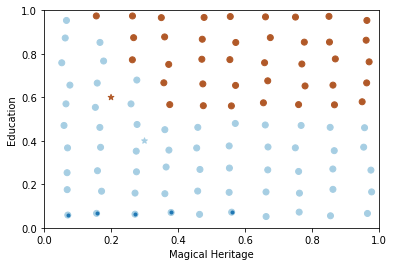

In [385]:
n = 5
top_n = True
# top_n = False
visualize_top_influential_points(X_train, y_train, influences_delete_trust, n, top_n, X_trust, y_trust)

# plotting

Plotting clusters...

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel

In [336]:
def visualize_top_influential_points(X_train, y_train, influences, n, top_n=True, X_trust=None, y_trust=None):
    influences.sort(key=lambda x:x[1], reverse=top_n)
    top_influence_indices = [i[0] for i in influences[:n]]
    
    top_influence_X = X_train[top_influence_indices,:]
    top_influence_y = y_train[top_influence_indices]
    
    plt.figure()
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker='o')
    
    plt.scatter(top_influence_X[:, 0], top_influence_X[:, 1], marker='.')
    
    if X_trust is not None:
        plt.scatter(X_trust[:, 0], X_trust[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='*')
    
    
    plt.xlabel('Magical Heritage')
    plt.ylabel('Education')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.draw()
    plt.show()

In [10]:
# ----------------------------------------
# For plotting data and decision boundary
def plot_model(X_train, y_train, clf, sigma, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):

	X = np.zeros((10000,2))
	a = np.linspace(0,1,100)
	b = np.linspace(0,1,100)
	e, d = np.meshgrid(a, b)
	X[:,0] = np.reshape(e,(10000,))
	X[:,1] = np.reshape(d,(10000,))

	K = rbf_kernel(X, X_train, gamma=(-1/(2.0*sigma**2)))
	Z = clf.predict(K)
	probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	Z = Z.reshape(e.shape)
	plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train, X_trust])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train[:, 0], X_train[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust is not None:
		plt.scatter(X_trust[:, 0], X_trust[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('Magical Heritage')
	plt.ylabel('Education')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.draw()

# HarryPotter

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel

In [351]:
# for reproducibility, fix the random seed 
np.random.seed(123)

# the learner is hard coded to be kernel logistic regression.
# learner's parameters:
lam = 1e3	# L2 regularization weight of learner
sigma = 0.4	# RBF kernel bandwidth
gamma = (-1/(2.0*sigma**2))

In [3]:
################### Harry Potter Toy Example ##################

# ----------------------------------------
# Generate "dirty" training data. 
# that is, we will plant some "historical bias" 
# in the form of labels: the Ministry of Magic refused to hire
# muggle-born graduates with high edcuation.

print("Creating training data...\n")

# Training Set size
n = 100 

# data points are on a uniform grid, then dithered with a Gaussian.
# x_1=magic heritage; x_2=education

X_train = np.zeros((n,2))
a = np.linspace(0.05, 0.95, num=int(np.sqrt(n)))
e, d = np.meshgrid(a, a)
X_train[:,0] = np.reshape(e,(n,))
X_train[:,1] = np.reshape(d,(n,))
X_train = X_train + 0.03*np.random.rand(n,2)
# print(X_train)

# the noiseless 'desired' label obeys y = sign(x_2 - 0.5)
y_clean = np.sign(X_train[:,1]-0.5)
# print(y_clean)

y_train = np.copy(y_clean)
y_train[(X_train[:,1]<(4*(X_train[:,0]-0.5)**2+0.5)) & (X_train[:,0]<0.5)] = -1
# print(y_train-y_clean)

Creating training data...



In [4]:
# --------------------------------------------------------------
# Generate trusted data
# we manually picked these two trusted items for pedagogical purpose
print("Creating trusted data...\n")

X_trust = np.array([[0.3, 0.4],[0.2, 0.6]])
y_trust = np.sign(X_trust[:,1]-0.5)
m = y_trust.shape[0]
c_value = 100  # Confidence parameters on trusted items are set to 100.
c = c_value*np.ones((m,1))

Creating trusted data...



In [5]:
y_train[y_train==-1] = 0
y_trust[y_trust==-1] = 0

In [6]:
print(X_train.shape, X_trust.shape)

(100, 2) (2, 2)


In [350]:
clf = LogisticRegression(solver='lbfgs', C=lam)

In [349]:
lam

1000.0